In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fastjet as fj
import time

In [2]:
# Generate mock particles
particles = []
np.random.seed(8)
n_jets = np.random.randint(5, 15)
#n_jets = 5
eta_values_list = []
phi_values_list = []
energy_values_list = []
print(n_jets)

8


In [3]:
for nj in range(n_jets):
    phi_0 = np.random.uniform(-np.pi, np.pi)
    eta_0 = np.random.uniform(-3, 3)
    Nj = np.random.randint(5, 15)
    eta_values = []
    phi_values = []
    energy_values = []
    for n_part in range(Nj):
        E = np.random.exponential(4)
        eta = np.random.normal(eta_0, 0.4)
        phi = np.random.normal(phi_0, 0.4)
        px = E * np.cos(phi)
        py = E * np.sin(phi)
        pz = E * np.sinh(eta)
        particles.append(fj.PseudoJet(px, py, pz, E))
        eta_values.append(eta)
        phi_values.append(phi)
        energy_values.append(E)
    
    eta_values_list.append(eta_values)
    phi_values_list.append(phi_values)
    energy_values_list.append(energy_values)

# Convert particle data to numpy array for clustering
particle_data = np.array([[p.eta(), p.phi(), p.pt(), p.e()] for p in particles])
#particle_data = np.array([[p.eta(), p.phi(), p.pt(), p.e(), p.px(), p.py(), p.pz()] for p in particles])


In [4]:
# Create FastJet particles
fj_particles = [fj.PseudoJet(p[0], p[1], p[2], np.sqrt(p[0]**2 + p[1]**2 + p[2]**2)) for p in particle_data]

# Define the radius parameter for jet clustering
R = 0.4

# FastJet algorithms
jet_definitions = {
    'Cambridge': fj.JetDefinition(fj.cambridge_algorithm, R),
    'kt': fj.JetDefinition(fj.kt_algorithm, R),
    'anti-kt': fj.JetDefinition(fj.antikt_algorithm, R)
}

In [41]:
# Custom Cambridge algorithm considering pt
def delta_r(p1, p2):
    delta_eta = p1[0] - p2[0]
    delta_phi = np.abs(p1[1] - p2[1])
    if delta_phi > np.pi:
        delta_phi = 2 * np.pi - delta_phi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def cambridge_algorithm(data, R):
    start_time = time.time()
    n_particles = data.shape[0]
    pt = data[:, 2]
    distances = np.zeros((n_particles, n_particles))
    
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            distances[i, j] = delta_r(data[i], data[j])
            distances[j, i] = distances[i, j]
    
    clusters = np.arange(n_particles)
    active = np.ones(n_particles, dtype=bool)
    p4_values = {i: [data[i, 4:8]] for i in range(n_particles)} 
    
    while True:
        min_dist = np.inf
        merge_pair = (-1, -1)
        
        for i in range(n_particles):
            if not active[i]:
                continue
            for j in range(i + 1, n_particles):
                if not active[j]:
                    continue
                dist_ij = distances[i, j] / R
                if dist_ij < min_dist:
                    min_dist = dist_ij
                    merge_pair = (i, j)
                            
        if min_dist > 1:
            break

        pt_sum = pt[merge_pair[0]] + pt[merge_pair[1]]
        eta_sum = (pt[merge_pair[0]] * data[merge_pair[0], 0] + pt[merge_pair[1]] * data[merge_pair[1], 0]) / pt_sum
        phi_sum = (pt[merge_pair[0]] * data[merge_pair[0], 1] + pt[merge_pair[1]] * data[merge_pair[1], 1]) / pt_sum
        data[merge_pair[0], 0] = eta_sum
        data[merge_pair[0], 1] = phi_sum
        data[merge_pair[0], 2] = pt_sum
        
        for k in range(n_particles):
            if k == merge_pair[0] or not active[k]:
                continue
            distances[merge_pair[0], k] = delta_r(data[merge_pair[0]], data[k])
            distances[k, merge_pair[0]] = distances[merge_pair[0], k]
        distances[:, merge_pair[1]] = 100
        distances[merge_pair[1], :] = 100
        
        active[merge_pair[1]] = False
        clusters[merge_pair[1]] = merge_pair[0]
        p4_values[merge_pair[0]].extend(p4_values[merge_pair[1]])
        p4_values[merge_pair[1]] = []
    
    end_time = time.time()
    t = end_time - start_time
    print("Time required for cambridge clustering in seconds is(Sakshi): ", t)
    
    return clusters, p4_values

In [42]:
# Custom anti-kt algorithm
def anti_kt_algorithm(data, R):
    n_particles = data.shape[0]
    pt = data[:, 2]
    distances = np.zeros((n_particles, n_particles))
    
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            distances[i, j] = delta_r(data[i], data[j])
            distances[j, i] = distances[i, j]
    
    clusters = np.arange(n_particles)
    active = np.ones(n_particles, dtype=bool)
    p4_values = {i: [data[i, 4:8]] for i in range(n_particles)}

    while True:
        min_dist = np.inf
        merge_pair = (-1, -1)
        
        for i in range(n_particles):
            if not active[i]:
                continue
            for j in range(i + 1, n_particles):
                if not active[j]:
                    continue
                dist_ij = min(pt[i]**-2, pt[j]**-2) * (distances[i, j]**2 / R**2)
                if dist_ij < min_dist:
                    min_dist = dist_ij
                    merge_pair = (i, j)
                    
        if min_dist > 1:
            break

        pt_sum = pt[merge_pair[0]] + pt[merge_pair[1]]
        eta_sum = (pt[merge_pair[0]] * data[merge_pair[0], 0] + pt[merge_pair[1]] * data[merge_pair[1], 0]) / pt_sum
        phi_sum = (pt[merge_pair[0]] * data[merge_pair[0], 1] + pt[merge_pair[1]] * data[merge_pair[1], 1]) / pt_sum
        data[merge_pair[0], 0] = eta_sum
        data[merge_pair[0], 1] = phi_sum
        data[merge_pair[0], 2] = pt_sum
        
        for k in range(n_particles):
            if k == merge_pair[0] or not active[k]:
                continue
            distances[merge_pair[0], k] = delta_r(data[merge_pair[0]], data[k])
            distances[k, merge_pair[0]] = distances[merge_pair[0], k]
        distances[:, merge_pair[1]] = 100
        distances[merge_pair[1], :] = 100
        
        active[merge_pair[1]] = False
        clusters[merge_pair[1]] = merge_pair[0]
        p4_values[merge_pair[0]].extend(p4_values[merge_pair[1]])
        p4_values[merge_pair[1]] = []
    
    end_time = time.time()
    t = end_time - start_time
    print("Time required for anti kt clustering in seconds is(Sakshi): ", t)
    
    return clusters, p4_values

In [43]:
# Custom kt algorithm
def kt_algorithm(data, R):
    n_particles = data.shape[0]
    pt = data[:, 2]
    distances = np.zeros((n_particles, n_particles))
    
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            distances[i, j] = delta_r(data[i], data[j])
            distances[j, i] = distances[i, j]
    
    clusters = np.arange(n_particles)
    active = np.ones(n_particles, dtype=bool)
    p4_values = {i: [data[i, 4:8]] for i in range(n_particles)}

    while True:
        min_dist = np.inf
        merge_pair = (-1, -1)
        
        for i in range(n_particles):
            if not active[i]:
                continue
            for j in range(i + 1, n_particles):
                if not active[j]:
                    continue
                dist_ij = min(pt[i]**2, pt[j]**2) * distances[i, j]**2 / R**2
                if dist_ij < min_dist:
                    min_dist = dist_ij
                    merge_pair = (i, j)
                            
        if min_dist > 1:
            break
        
        pt_sum = pt[merge_pair[0]] + pt[merge_pair[1]]
        eta_sum = (pt[merge_pair[0]] * data[merge_pair[0], 0] + pt[merge_pair[1]] * data[merge_pair[1], 0]) / pt_sum
        phi_sum = (pt[merge_pair[0]] * data[merge_pair[0], 1] + pt[merge_pair[1]] * data[merge_pair[1], 1]) / pt_sum
        data[merge_pair[0], 0] = eta_sum
        data[merge_pair[0], 1] = phi_sum
        data[merge_pair[0], 2] = pt_sum
        
        for k in range(n_particles):
            if k == merge_pair[0] or not active[k]:
                continue
            distances[merge_pair[0], k] = delta_r(data[merge_pair[0]], data[k])
            distances[k, merge_pair[0]] = distances[merge_pair[0], k]
        distances[:, merge_pair[1]] = 100
        distances[merge_pair[1], :] = 100
        
        active[merge_pair[1]] = False
        clusters[merge_pair[1]] = merge_pair[0]
        p4_values[merge_pair[0]].extend(p4_values[merge_pair[1]])
        p4_values[merge_pair[1]] = []
    
    end_time = time.time()
    t = end_time - start_time
    print("Time required for kt clustering in seconds is(Sakshi): ", t)
    
    return clusters, p4_values


In [44]:
# Run the custom Cambridge algorithm
R = 0.4
start_time = time.time()
custom_clusters_cambridge, _ = cambridge_algorithm(particle_data, R)
end_time = time.time()
cambridge_time = end_time - start_time
unique_cambridge_clusters = np.unique(custom_clusters_cambridge)

# Run the custom kT algorithm
start_time = time.time()
custom_clusters_kt, _ = kt_algorithm(particle_data, R)
end_time = time.time()
kt_time = end_time - start_time
unique_kt_clusters = np.unique(custom_clusters_kt)

# Run the custom anti-kT algorithm
start_time = time.time()
custom_clusters_antikt, _ = anti_kt_algorithm(particle_data, R)
end_time = time.time()
antikt_time = end_time - start_time
unique_antikt_clusters = np.unique(custom_clusters_antikt)

Time required for cambridge clustering in seconds is(Sakshi):  0.32280731201171875
Time required for kt clustering in seconds is(Sakshi):  0.39960217475891113
Time required for anti kt clustering in seconds is(Sakshi):  0.6429028511047363


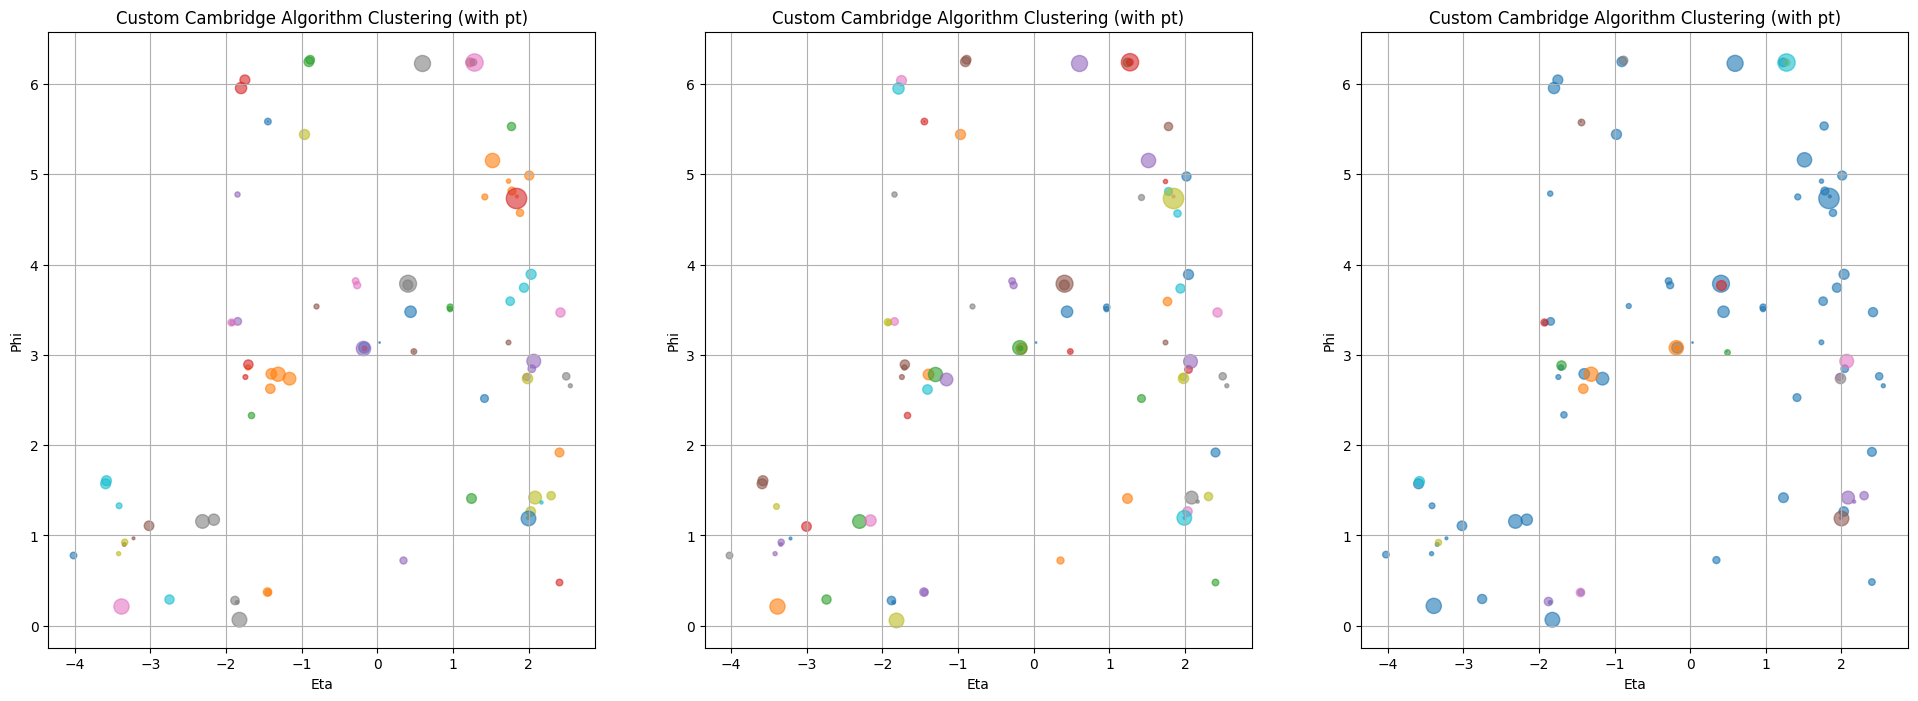

In [53]:
# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot the particles with custom Cambridge algorithm clusters
ax = axes[0]
for cluster in unique_cambridge_clusters:
    cluster_indices = np.where(custom_clusters_cambridge == cluster)[0]
    eta_values = particle_data[cluster_indices, 0]
    phi_values = particle_data[cluster_indices, 1]
    energy_values = particle_data[cluster_indices, 3]
    eta_center = np.mean(eta_values)
    phi_center = np.mean(phi_values)
    ax.scatter(eta_values, phi_values, s=energy_values * 10, alpha=0.6, label=f'Cluster {cluster}')
ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_title('Custom Cambridge Algorithm Clustering (with pt)')
ax.grid(True)


# Plot the particles with custom kT algorithm clusters
ax = axes[1]
for cluster in unique_kt_clusters:
    cluster_indices = np.where(custom_clusters_kt == cluster)[0]
    eta_values = particle_data[cluster_indices, 0]
    phi_values = particle_data[cluster_indices, 1]
    energy_values = particle_data[cluster_indices, 3]
    eta_center = np.mean(eta_values)
    phi_center = np.mean(phi_values)
    ax.scatter(eta_values, phi_values, s=energy_values * 10, alpha=0.6, label=f'Cluster {cluster}')
ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_title('Custom kt Algorithm Clustering (with pt)')
ax.grid(True)

# Plot the particles with custom anti-kT algorithm clusters
ax = axes[2]
for cluster in unique_antikt_clusters:
    cluster_indices = np.where(custom_clusters_antikt == cluster)[0]
    eta_values = particle_data[cluster_indices, 0]
    phi_values = particle_data[cluster_indices, 1]
    energy_values = particle_data[cluster_indices, 3]
    eta_center = np.mean(eta_values)
    phi_center = np.mean(phi_values)
    ax.scatter(eta_values, phi_values, s=energy_values * 10, alpha=0.6, label=f'Cluster {cluster}')
ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_title('Custom Anti-kt Algorithm Clustering (with pt)')
ax.grid(True)

plt.show()

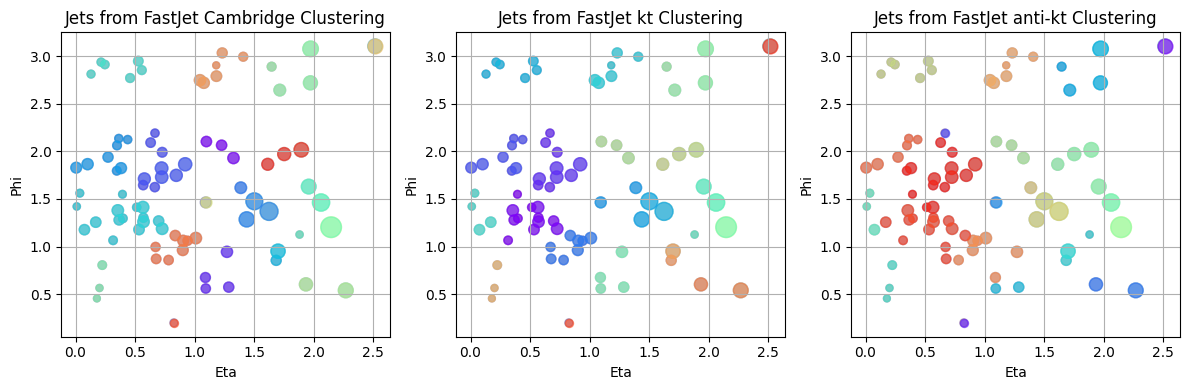

In [11]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(12,4))

for i, (alg_name, jet_def) in enumerate(jet_definitions.items()):
    # Cluster jets using FastJet
    jet_cluster = fj.ClusterSequence(fj_particles, jet_def)
    jets = jet_cluster.inclusive_jets()

    # Plot the particles
    eta_values = [p.eta() for p in fj_particles]
    phi_values = [p.phi() for p in fj_particles]
    energy_values = [p.E() for p in fj_particles]
    axs[i].scatter(eta_values, phi_values, c=energy_values, cmap='viridis', s=np.array(energy_values)*10, alpha=0.4, label='Particles')

    # Use the rainbow colormap to assign colors to the jets
    cmap = plt.cm.rainbow
    jet_colors = [cmap(j / len(jets)) for j in range(len(jets))]

    # Plot the jets and their constituents
    for j, jet in enumerate(jets):
        jet_eta_values = [p.eta() for p in jet.constituents()]
        jet_phi_values = [p.phi() for p in jet.constituents()]
        jet_energy_values = [p.E() for p in jet.constituents()]
        axs[i].scatter(jet_eta_values, jet_phi_values, c=[jet_colors[j % len(jet_colors)]]*len(jet_eta_values), s=np.array(jet_energy_values)*10, alpha=0.6, label=f'Jet {j+1}')
        #axs[i].scatter(jet.eta(), jet.phi(), color='none', marker='o', s=300, edgecolor='black', label=f'Jet {j+1} center')

    # Add plot details
    axs[i].set_xlabel('Eta')
    axs[i].set_ylabel('Phi')
    axs[i].set_title(f'Jets from FastJet {alg_name} Clustering')
    axs[i].grid(True)

plt.tight_layout()
plt.show()